<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Необходимо построить модель предсказания, привлечения количества водителей в зависимости от  периода пиковой нагрузки, т.е. спрогнозировать количество заказов такси на следующий час. 
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. 

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

In [1]:
import warnings
warnings.simplefilter(action='ignore')# Игнорировать все предупреждения

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

In [2]:
df_taxi = pd.read_csv('/datasets/taxi.csv', index_col=['datetime'], parse_dates=['datetime'])
df_taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим, в хронологическом ли порядке расположены даты и время.

In [4]:
df_taxi.sort_index(inplace=True)
df_taxi.index.is_monotonic

True

is_monotonic=True - в хронологическом

In [5]:
df_taxi.index.min(), df_taxi.index.max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:50:00'))

### Вывод

В  датасете 26496 строк 1 столбец. 

Пропуски отсутствуют.

В столбце num_orders тип данных int64.

Дата была сразу переведена в формат DateTime и помещена в индекс при загрузке исходных данных.

Представлен временной период  с 2018-03-01 по 2018-08-31 расположен в хронологическом порядке.

Целевой признак: num_orders - количество заказов.

## Анализ

Визуализируем данные

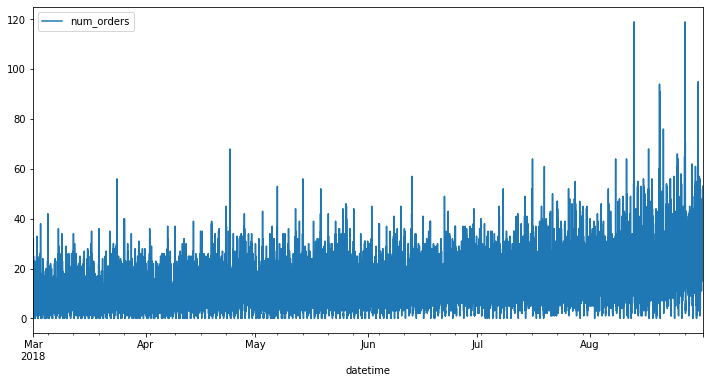

In [6]:
df_taxi.plot(figsize=(12,6))

Исходные данные изменяются раз в 10 минут.
Проведем ресемплирование по одному часу.

In [7]:
df_taxi = df_taxi.resample('1H').sum()

Как можно заметить, график имеет яркие выбросы. Посмотрим на данные взависимости от месяца

In [8]:
df_taxi_study=df_taxi.copy()

Text(0.5, 0, 'месяц')

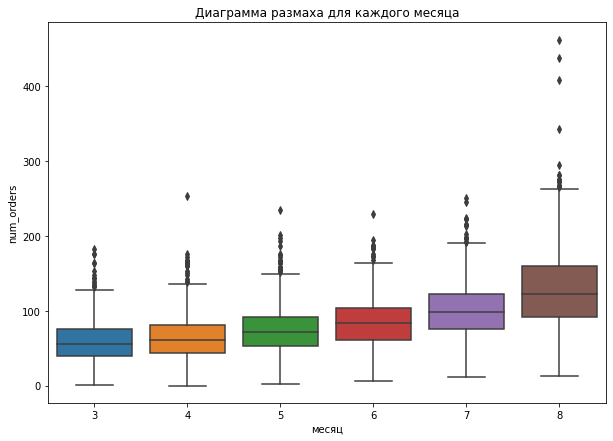

In [9]:
df_taxi_study['Month'] = df_taxi_study.index.month
fig, axes = plt.subplots(figsize=(10, 7), sharex=True)
sns.boxplot(data=df_taxi_study, x='Month', y='num_orders')
plt.title("Диаграмма размаха для каждого месяца")
plt.xlabel("месяц")

Можем видеть, как изменяются данные о заказах такси в зависимости от месяца.
Каждый месяц характеризуется наличием выбросов, однако среднее для всех месяцев примерно одинаковое.

Посмотрим на характеристики и гистограмму представленного датафрейма.

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


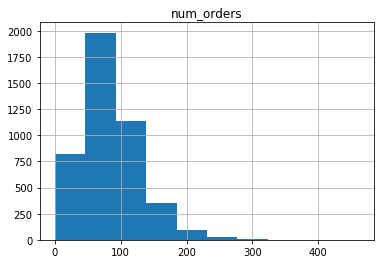

In [10]:
df_taxi_describe = df_taxi.describe()
df_taxi.hist()
df_taxi_describe

Среднее равно 14,070463. Данные имеют нормальное распределение с отклонением вправо.

Расчитаем коэффициент вариации — это величина, используемая в статистике, равная отношению стандартного (среднеквадратичного) отклонения случайной величины к ее математическому ожиданию:

CV=(σ/k)∗100,

где  σ – среднеквадратическое отклонение случайной величины; 
      
    k- ожидаемое (среднее) значение случайной величины.

* если коэффициент вариации меньше 10%, то степень рассеивания данных считается незначительной;
* если от 10% до 20% — средней;
* больше 20% и меньше или равно 33% — значительной.

Если значение коэффициента вариации не превышает 33%, то совокупность считается однородной, а если больше 33%, то – неоднородной.

In [11]:
print('V =', df_taxi_describe.num_orders['std']/df_taxi_describe.num_orders['mean']*100)

V = 53.33140296285983


Рассчитанная величина свидетельствует о неоднородности данных о заказах такси в аэропортах, т.к. однородной совокупность считается, если коэффициент вариации меньше 33% (для распределений близких к нормальному), и следовательно данные значительно разбросаны относительно среднего значения.

Проверим наш ряд на стационарность

In [12]:
test = sm.tsa.adfuller(df_taxi['num_orders'])
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -3.068924289027949
p-value:  0.02894005140261345
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
единичных корней нет, ряд стационарен


Исследуем временной ряд на тренды и сезонность

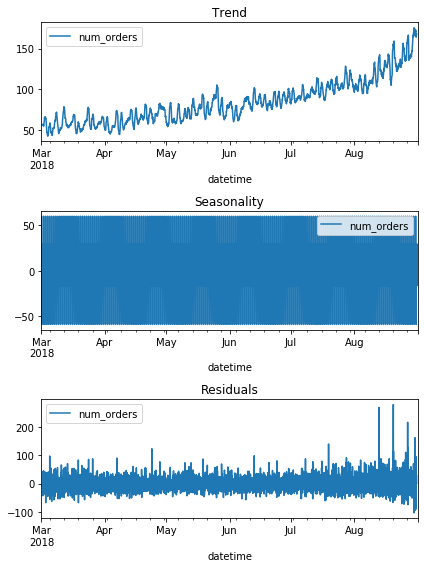

In [13]:
decomposed = seasonal_decompose(df_taxi) 

plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Исследуем временной ряд на тренды и сезонность за последние 10 дней выборки.

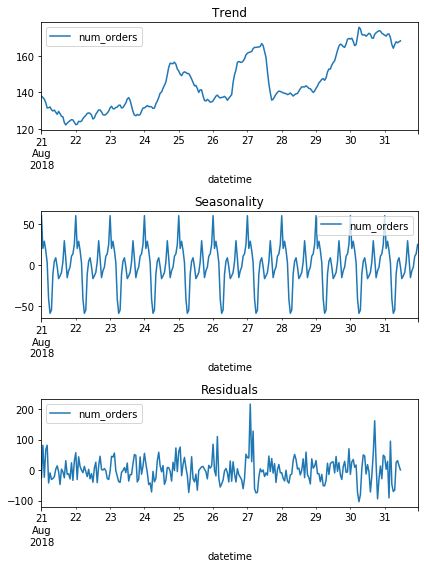

In [14]:
decomposed = seasonal_decompose(df_taxi) 
plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend['2018-08-21':'2018-08-31'].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-08-21':'2018-08-31'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid['2018-08-21':'2018-08-31'].plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Тренд - это общая тенденция - восходящий.

Сезонность - влияния периодичности - дневная цикличность. Видим, что частотата заказов возрастает к концу дня. В течение ночи резко убывает и затем начинает снова наростать.

Шум - это случайные факторы - присутствуют.

Посмотрим на степень линейной статистической связи между значениями временного ряда построив автокорреляционную функцию. 

Функция автокорреляции (ACF). При лаге k это корреляция между рядами значений, отстоящих друг от друга на k интервалов. 

Функция частной автокорреляции (PACF). При лаге k это корреляция между рядами значений, отстоящих друг от друга на k интервалов, считая значения интервалов в промежутке.

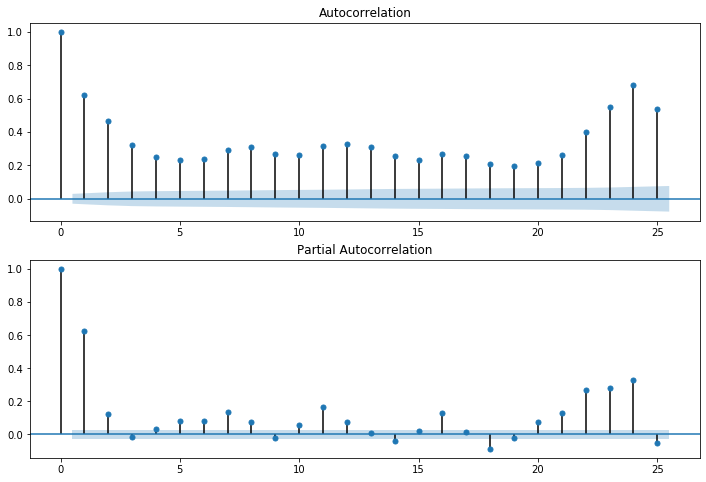

In [15]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_taxi['num_orders'].values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_taxi['num_orders'], lags=25, ax=ax2)

Значения ACF и PACF для лагов 1 и 24 максимальны, говорят о выраженной дневной цикличности  рассматриваемого ряда.

### Вывод

Анализ временного ряда показал, что:
* имеются выбросы;
* ряд стационарен, но неоднороден;
* данные имеют нормальное распределение с отклонением вправо;
* тренд - восходящий;
* сезонность - присутствует и равна суткам;
* максимальные значения ACF и PACF для лагов 1 и 24.

## Обучение

Напишем функцию make_features() (англ. «создать признаки»), чтобы прибавить к таблице четыре новых календарных признака: год, месяц, день и день недели. Имена столбцов должны быть такие: 'year', 'month', 'day', 'dayofweek'.
Cнизим колебания во временном ряду, применив скользящее среднее.
Скользящее среднее (англ. rolling mean), или движущееся среднее (англ. moving average), — метод сглаживания временных рядов.

In [16]:
def make_features(data, max_lag, rolling_mean_size):
    new_data = data.copy(deep=True)
    new_data['year'] = new_data.index.year
    new_data['month'] = new_data.index.month
    new_data['day'] = new_data.index.day
    new_data['dayofweek'] = new_data.index.dayofweek

    for i in range(1,max_lag+1):
        new_data['lag_{}'.format(i)]=new_data['num_orders'].shift(i)
    new_data['rolling_mean']=new_data['num_orders'].shift().rolling(window=rolling_mean_size).mean()
    
    train, test = train_test_split(new_data, shuffle=False, test_size=0.1)
    train = train.dropna()
    
    X_train = train.drop(['num_orders'], axis=1)
    y_train = train['num_orders']
    
    X_test = test.drop(['num_orders'], axis=1)
    y_test = test['num_orders']
    
    return X_train, y_train, X_test, y_test 

In [17]:
features_train, target_train, features_test, target_test  = make_features(df_taxi, 168, 168)

In [18]:
print(features_train.index.min(), features_train.index.max())
print(features_test.index.min(), features_test.index.max())
print('Размер обучающей выборки: {} объектов, {} признаков'.format(features_train.shape[0], features_train.shape[1]))
print('Размер тестовой выборки: {} объектов, {} признаков'.format(features_test.shape[0], features_test.shape[1]))

2018-03-08 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00
Размер обучающей выборки: 3806 объектов, 173 признаков
Размер тестовой выборки: 442 объектов, 173 признаков


Напишем функции rmse_scorer и rmse_model, и обучим следующие модели регрессии:
* LinearRegression - линейной регрессии
* RandomForestRegressor - случайный лес для регрессии
* LGBMRegressor - градиентный бустинг и модель линейной регрессии

Оценим точность предсказания по метрике RMSE.

In [19]:
def rmse_scorer(targ, pred):
    return (mean_squared_error(targ, pred)** 0.5)

my_scorer = make_scorer(rmse_scorer, greater_is_better=False)


def rmse_model(model, feat_tr, targ_tr):
    model_study = model
    model_study.fit(feat_tr, targ_tr)

    predicted = model_study.predict(feat_tr) 
   
    RMSE = rmse_scorer (targ_tr, predicted)# квадратный корень из средней квадратичной ошибки

    return RMSE

In [20]:
rmse_LR = rmse_model(LinearRegression(), features_train, target_train)

In [21]:
rmse_RFR = rmse_model(RandomForestRegressor(),  features_train, target_train)

In [22]:
rmse_LGBMR = rmse_model(LGBMRegressor(), features_train, target_train)

In [23]:
model_train = pd.DataFrame({'Модель': ['LinearRegression','RandomForestRegressor','LGBMRegressor'],
                'Параметры': ['-',  '-',  '-'], 
                'RMSE': [rmse_LR, rmse_RFR, rmse_LGBMR]})
model_train

,Модель,Параметры,RMSE
0,LinearRegression,-,20.328394
1,RandomForestRegressor,-,9.594511
2,LGBMRegressor,-,9.195034


Подберем гиперпараметры для  моделей и проверим как изменится метрика RMSE.

In [24]:
# модели, которые сравниваются
models = {
     'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(),
    'LGBMRegressor()': LGBMRegressor() 
}

# параметры оптимизации для каждой из вышеперечисленных моделей
params = {
       'LinearRegression': {
            'fit_intercept':[True, False], 
            'normalize':[True, False], 
            'copy_X':[True, False]
    },
        'RandomForestRegressor':{
             'n_estimators': [10, 100, 200], 
              'max_features': [2, 4, 6, 8],  
              'max_depth':[3, 6, 9]
    },

    'LGBMRegressor()': {
         'max_depth': [-1, 3, 5],
         'n_estimators': [100, 200]
    }
}

In [25]:
cv = TimeSeriesSplit(n_splits=4) #это вариант k-фолд возврата, , разделение создается только в соответствии с порядком, в котором появляются записи..

In [26]:
def fit(train_features, train_actuals):
        """
        fits the list of models to the training data, thereby obtaining in each 
        case an evaluation score after GridSearchCV cross-validation
        """

        for name in models.keys():
            est = models[name]
            est_params = params[name]
            gscv = GridSearchCV(estimator=est, param_grid=est_params, scoring=my_scorer, 
                                cv=cv, n_jobs=-1)
            gscv.fit(train_actuals, train_features)
            print("best parameters are: {}".format(gscv.best_estimator_))

In [27]:
fit(target_train, features_train)

best parameters are: LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
best parameters are: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
best parameters are: LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=3,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsampl

In [28]:
rmse_LR = rmse_model(LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True), features_train, target_train)

In [29]:
rmse_RFR = rmse_model(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False),  features_train, target_train)

In [30]:
rmse_LGBMR = rmse_model(LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0), features_train, target_train)

In [31]:
model_train_param = pd.DataFrame({'Модель': ['LinearRegression','RandomForestRegressor','LGBMRegressor'],
                'Параметры': ['copy_X=True, fit_intercept=False, n_jobs=None, normalize=True',  
                              'max_depth=9, max_features=8, n_estimators=200', 
                              'max_depth=-1, n_estimators=100'], 
                'RMSE': [rmse_LR, rmse_RFR, rmse_LGBMR]})
model_train_param

,Модель,Параметры,RMSE
0,LinearRegression,"copy_X=True, fit_intercept=False, n_jobs=None,...",20.344587
1,RandomForestRegressor,"max_depth=9, max_features=8, n_estimators=200",15.651090
2,LGBMRegressor,"max_depth=-1, n_estimators=100",9.195034


### Вывод

Были рассмотрены три модели:  LinearRegression, RandomForestRegressor, LGBMRegressor.
Наилучшее значение RMSE = 9.195034 выявлено у  LGBMRegressor, однако после подбора гиперпараметров с помощью GridSearchCV ситуация изменилась.
Лучшим показателем RMSE = 9.195034 обладает модель LGBMRegressor с гиперпараметрами: max_depth=-1, n_estimators=100.

## Тестирование

Проведем тестирование лучшей модели с подобранными гиперпараментрами и визуализируем результат.

In [32]:
model = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
model.fit(features_train, target_train)

predicted_test = model.predict(features_test) 
print('RMSE:', rmse_scorer(target_test, predicted_test))# квадратный корень из средней квадратичной ошибки

RMSE: 36.13292175177176


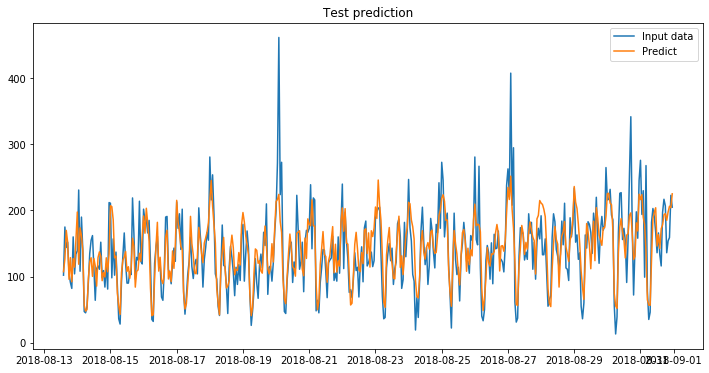

In [33]:
plt.figure(figsize=(12, 6))

plt.plot(target_test, label='Input data')
plt.plot(target_test.index, predicted_test, label='Predict')

plt.title('Test prediction')
plt.legend()
plt.show()

### Вывод

В работе проанализирован ресемплированый  по 1 часу временной ряд заказов такси в аэропортах.
Показано, что:
* имеются выбросы;
* ряд стационарен, но неоднороден;
* данные имеют нормальное распределение с отклонением вправо;
* тренд - восходящий;
* сезонность - присутствует и равна суткам;
* максимальные значения ACF и PACF для лагов 1 и 24.

Из трех рассматриваемых моделей: LinearRegression, RandomForestRegressor, LGBMRegressor выбрана одна модель имеющая наилучший показатель метрики RMSE = 2.059239 на обучающей выборке после подбора гиперпараметров, равными max_depth=-1, n_estimators=100 - LGBMRegressor.

На тестовых данных у модели LGBMRegressor метрика RMSE имеет значение  36.13292175177176, что не превышает определенного заданием порога 48.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48